In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

In [13]:
dataframe = pd.read_csv('GE.csv')
df = dataframe[['Date', 'Close']]
df['Date'] = pd.to_datetime(df.loc[:,'Date'])

/tmp/ipykernel_31035/3496727502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df.loc[:,'Date'])


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Close   252 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


<Axes: xlabel='Date', ylabel='Close'>

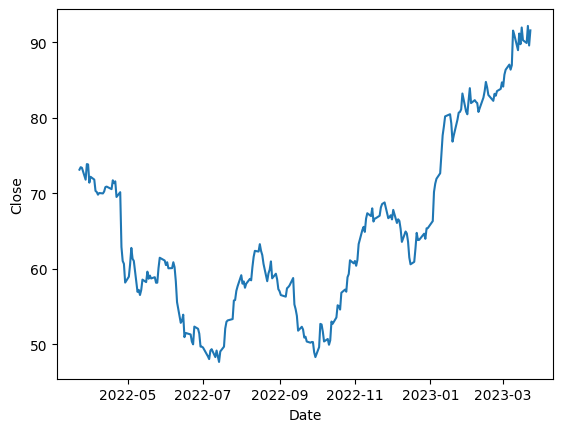

In [15]:
sns.lineplot(x=df['Date'], y=df['Close'])

In [16]:
print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

Start date is:  2022-03-23 00:00:00
End date is:  2023-03-23 00:00:00


In [17]:
train, test = df.loc[df['Date'] <= '2023-01-01'], df.loc[df['Date'] > '2023-01-01']

In [19]:
print(train.shape)
print(test.shape)

(196, 2)
(56, 2)


In [21]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/tmp/ipykernel_31035/1980345901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
/tmp/ipykernel_31035/1980345901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [26]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 30  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

In [27]:
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []
    
    for i in range(len(x) - seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

In [30]:
trainX, trainY = to_sequences(train[['Close']], train[['Close']], seq_size)
testX, testY = to_sequences(test[['Close']], test[['Close']], seq_size)

In [35]:
#Try another model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

2023-03-24 17:24:10.727400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 17:24:10.727532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 17:24:10.755808: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-24 17:24:10.755827: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to do

In [36]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
5/5 [==============================] - 2s 83ms/step - loss: 0.5483 - val_loss: 0.2461
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.3188 - val_loss: 0.2366
Epoch 3/10
5/5 [==============================] - 0s 13ms/step - loss: 0.2628 - val_loss: 0.2472
Epoch 4/10
5/5 [==============================] - 0s 16ms/step - loss: 0.2269 - val_loss: 0.2478
Epoch 5/10
5/5 [==============================] - 0s 17ms/step - loss: 0.2110 - val_loss: 0.2366
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 0.2075 - val_loss: 0.2068
Epoch 7/10
5/5 [==============================] - 0s 16ms/step - loss: 0.2077 - val_loss: 0.1971
Epoch 8/10
5/5 [==============================] - 0s 17ms/step - loss: 0.1955 - val_loss: 0.1962
Epoch 9/10
5/5 [==============================] - 0s 15ms/step - loss: 0.1901 - val_loss: 0.1929
Epoch 10/10
5/5 [==============================] - 0s 14ms/step - loss: 0.1899 - val_loss: 0.1998


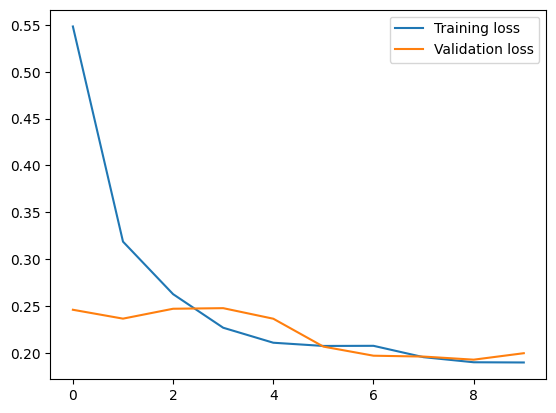

In [39]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [38]:
model.evaluate(testX, testY)

1/1 [==============================] - 0s 14ms/step - loss: 0.9473


0.9473390579223633

6/6 [==============================] - 0s 6ms/step


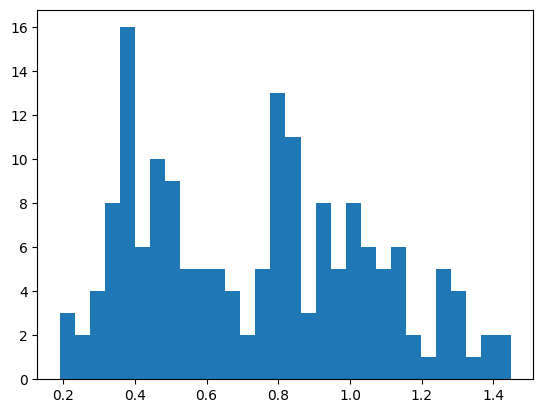

In [49]:
###########################
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

1/1 [==============================] - 0s 13ms/step


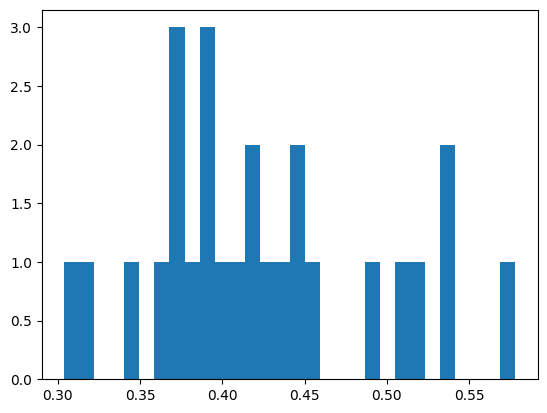

In [51]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30);

In [42]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

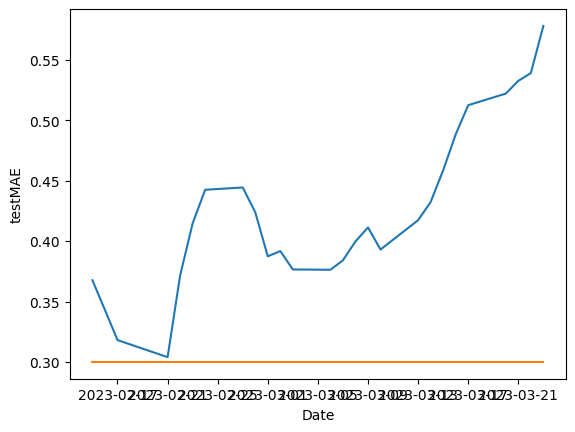

In [44]:
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE']);

In [63]:
anomaly_df['Close'].shape

(26,)

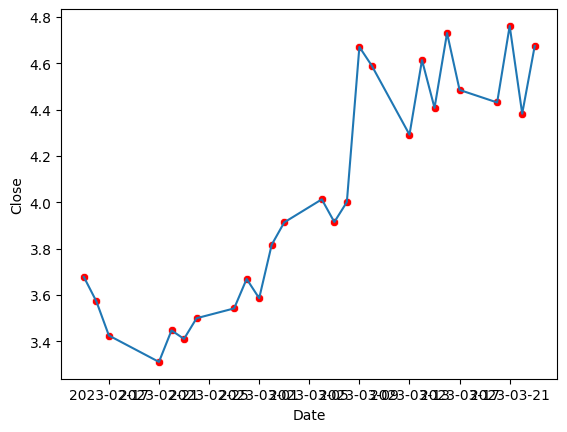

In [65]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['Close'])
sns.scatterplot(x=anomalies['Date'], y=anomalies['Close'], color='r');